<a href="https://colab.research.google.com/github/vgutierrezmendivil/NeuralNetworks/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Autores: Victoria Gutierrez y Cecilia Sanseverino**

# Entregable

1. Implementar el perceptrón multicapa y la red neuronal convolucional solicitadas.

2. Para el caso de la red neuronal convolucional, realizar el cálculo del tamaño de la entrada y salida en cada capa convolucional en función de los parámetros de cada capa (tamaño del kernel, padding, stride, etc) para garantizar que los tensores que fluyen por la red sean del tamaño adecuado. Indicar el tamaño de los feature maps a medida que fluyen por la red.

3. Comparar la accuracy obtenida por el perceptrón muticapa y la red neuronal convolucional.

Cargamos los datos:

100%|██████████| 9912422/9912422 [00:00<00:00, 71012781.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99700159.53it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38083941.26it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10842645.86it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


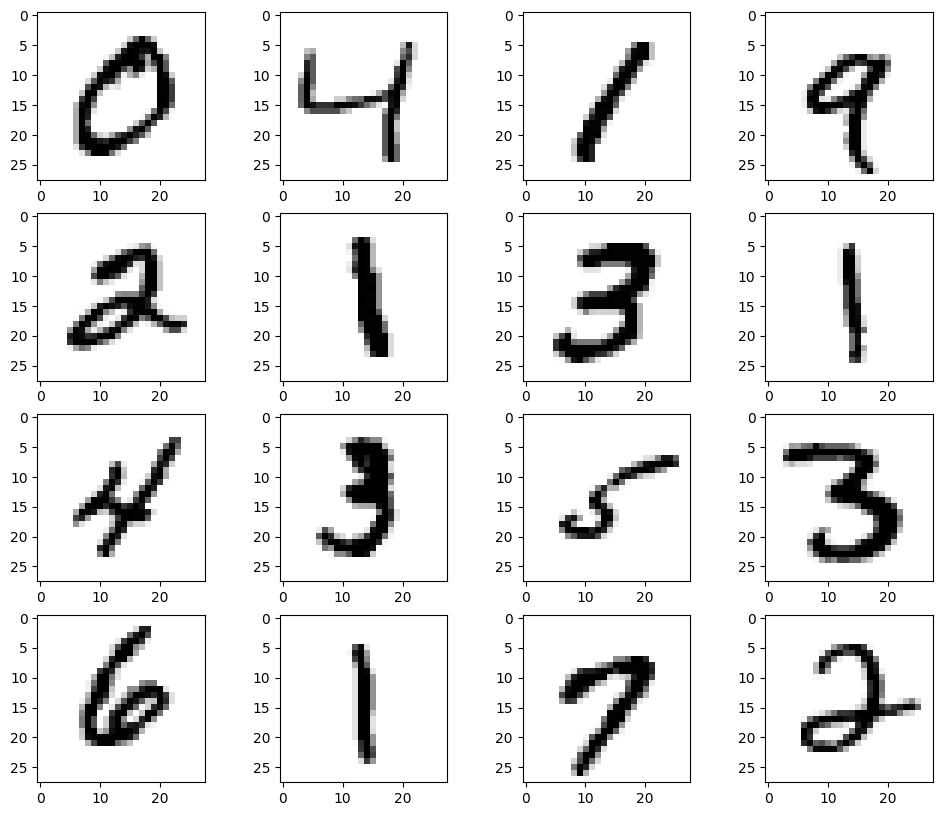

In [ ]:
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 10]

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))

In [ ]:
labels_train = mnist_train.targets.numpy()
labels_test = mnist_test.targets.numpy()

unique_train, counts_train = np.unique(labels_train, return_counts=True)
class_counts_train = dict(zip(unique_train, counts_train))

unique_test, counts_test = np.unique(labels_test, return_counts=True)
class_counts_test = dict(zip(unique_test, counts_test))

print("Conteo de imágenes por clase para train:")
print(class_counts_train)

print("Conteo de imágenes por clase para test:")
print(class_counts_test)

Conteo de imágenes por clase para train:
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Conteo de imágenes por clase para test:
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


Vemos que si bien cada clase no tiene exactamente la misma cantidad de datos, tanto en train como en test, la diferencia entre clases no supera el 27% en test y el 24 en train. Es decir, en el caso de test, la clase con mayor cantidad de datos tiene un 27% más datos que la clase menos representada.


## Punto 1) Perceptrón multicapa

Generamos un perceptrón mutlicapa para clasificar imágenes de 28 x 28 en 10 categorías diferentes, con la siguiente arquitectura:

* Reformatearmos la imagen de 28 x 28 a un vector de 784 componetes.
* Perceptrón con 15 neuronas en las capas intermedias.
* Última capa con 10 neuronas (clases).
* Función de pérdida: Entropía Cruzada.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class NetMLP(torch.nn.Module):
    def __init__(self, input_features, n_hidden, n_output):
        super(NetMLP, self).__init__()
        self.hidden1 = nn.Linear(input_features, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = x.view(-1, 784) # Formateamos la imagen de entrada a un vector con .view
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

Epoch 0, loss = 0.546137
Epoch 1, loss = 0.29583
Epoch 2, loss = 0.558268
Epoch 3, loss = 0.47676
Epoch 4, loss = 0.103537


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

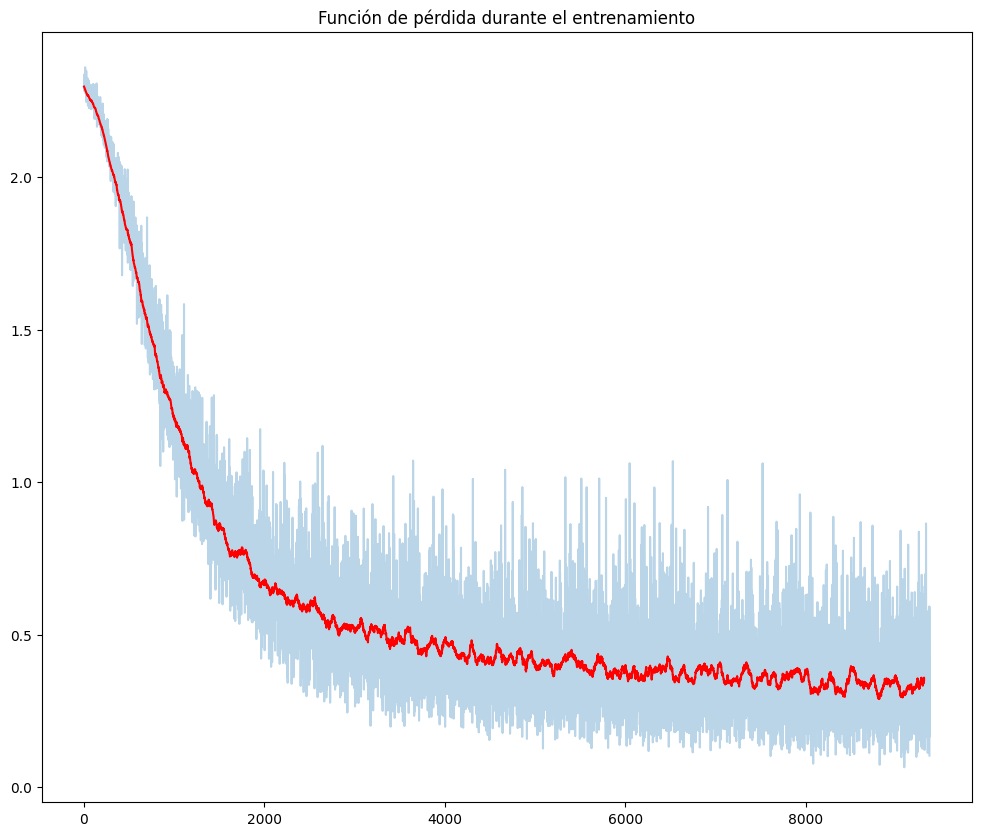

In [ ]:
# Parámetros
input_features = 28*28
hidden_neurons = 15
num_outputs = 10
batch_size = 50
learning_rate = 0.0001

# Mandamos los datos al GPU
device = torch.device('cuda:0')

# Instanciamos el modelo
net = NetMLP(input_features, hidden_neurons, num_outputs)
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar
# son los del modelo definido: net.parameters()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = nn.CrossEntropyLoss()

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Número de épocas
num_epochs = 5

# Lista en la que iremos guardando el valor de la función de pérdida en cada
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)

        # Realizo la pasada backward por la red
        loss.backward()

        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


Guardamos el modelo para poder reutilizarlo.

In [ ]:
torch.save(net.state_dict(), "./mlp20.pth")

Cargamos el modelo y visualizamos los resultados en los datos de test y mostramos la matriz de confusión.

In [ ]:
# Cargo el modelo guardado (si el modelo se encuentra en memoria, este paso no es necesario)
input_features = 28*28
hidden_neurons = 15
num_outputs = 10
net = NetMLP(input_features,hidden_neurons,num_outputs)
net.load_state_dict(torch.load("./mlp20.pth"))
net.to(device)

NetMLP(
  (hidden1): Linear(in_features=784, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.92      0.88      0.90      1032
           3       0.88      0.90      0.89      1010
           4       0.92      0.93      0.92       982
           5       0.89      0.82      0.85       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.85      0.86      0.86       974
           9       0.90      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



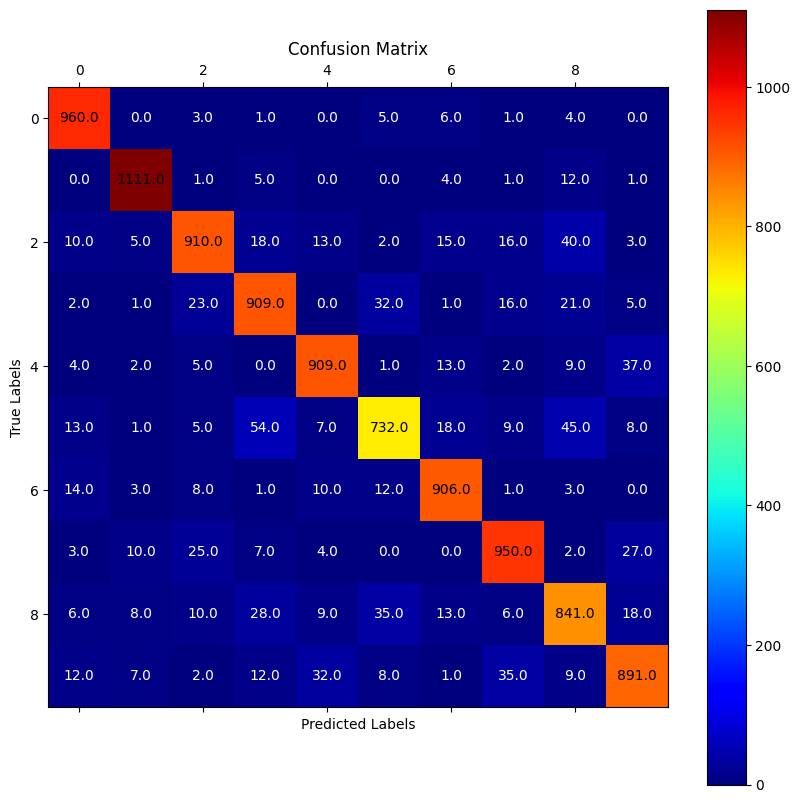

In [ ]:
def showTestResults(model):
  plt.rcParams['figure.figsize'] = [12, 10]
  from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

  # Generamos un data loader para leer los datos de test
  loader_test = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)
  x_test = list(loader_test)[0][0]
  y_test = list(loader_test)[0][1]

  # Movemos los tensores a la GPU y realizar las predicciones
  x_test = x_test.to(device)
  pred = model(x_test)

  # Decidir la clase asignada por mayor valor y calculo de accuracy
  pred_y = torch.max(pred.to("cpu"), 1)[1].data.numpy()
  acc_MLP = classification_report(y_test, pred_y)
  print(acc_MLP)

  # Matriz de confusion
  conf_mat = confusion_matrix(y_test, pred_y)
  plt.matshow(conf_mat, cmap='jet')
  for (i, j), z in np.ndenumerate(conf_mat):
      color = 'white' if conf_mat[i, j] < (conf_mat.max() / 2) else 'black'
      plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color=color)
  plt.title("Confusion Matrix")
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.colorbar()
  plt.show()

showTestResults(net)

Como podemos observar, este modelo tiene un accuracy de 0.91. El principal error de clasificación se da entre el 5 y el 4 (hay 54 cincos clasificados como cuatros) y entre 5 y el 8 (hay 45 cincos que fueron clasificados como ochos). Vemos que el f1-score del número 5 es el más bajo, con un valor de 0.85.

## Punto 2) Red Neuronal Convolucional

Definimos un modelo NetCNN que implemente una red neuronal convolucional, con la siguiente estructura:
* Capa convolucional (`nn.Conv2D`) (6 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa convolucional (`nn.Conv2D`) (16 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa totalmente conectada (`nn.Linear`) (120 neuronas) + ReLU
* Capa totalmente conectada (`nn.Linear`) (84 neuronas) + ReLU
* Capa de salida (`nn.Linear`) (10 neuronas)
* Función de pérdida: Cross Entropy.

Para simplificar el modelo y considerando que nuestras imagenes son todas de 28x28 píxeles, calculamos el tamaño de la entrada para la primera capa totalmente conectada en función de cómo las operaciones de convolución y max pooling cambian las dimensiones de la imagen, según la siguiente fórmula

$$
O = \frac{{W - F + 2P}}{{S}} + 1
$$

- O es la salida (tamaño de la salida).
- W es el tamaño de la entrada.
- F es el tamaño del filtro (kernel).
- P es el padding
- S es el stride

\\

En ningún caso habrá padding. En las capas convolucionales el stride será de 1, por lo que la fórmula se reduce a:

$$
O = {{W - F}} + 1
$$

En las capas de max pooling el stride es de 2, ya que por defecto el stride es igual al tamaño del kernel, por lo tanto la fórmula será:
$$
O = \frac{{W - F}}{{S}} + 1
$$

- La primera capa convolucional con un kernel de 3×3 y sin padding reduce la dimensión de 28 a 26.
$$
{{28 - 3}} + 1 = 26
$$
- La operación de max pooling con un kernel de 2×2 reduce la dimensión de 26 a 13.
$$
\frac{{26 - 2}}{{2}} + 1 = 13
$$
- La segunda capa convolucional nuevamente reduce cada dimensión en 2 (13 a 11).
$$
{{13 - 3}} + 1 = 11
$$
- La segunda operación de max pooling reduce de 11 a 5 (redondeamos hacia abajo).
$$
\frac{{11 - 2}}{{2}} + 1 = 5.5
$$
- Por último, la dimensión de salida después de la segunda operación de max pooling será 5×5 con 16 feature maps.

Otra forma de encarar este problema podría haber sido definir un método que calcule el tamaño de la entrada y luego ajuste las variables subsiguientes.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        # Primera capa convolucional
        self.conv1 = nn.Conv2d(1, 6, 3)
        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(6, 16, 3)
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Dimensiones de la imagen después de convoluciones y pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Capas convolucionales y max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 5 * 5)
        # Capas totalmente conectadas
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Entrenamos la red convolucional:

Epoch 0, loss = 0.220502
Epoch 1, loss = 0.434138
Epoch 2, loss = 0.106267
Epoch 3, loss = 0.108258
Epoch 4, loss = 0.0811267


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

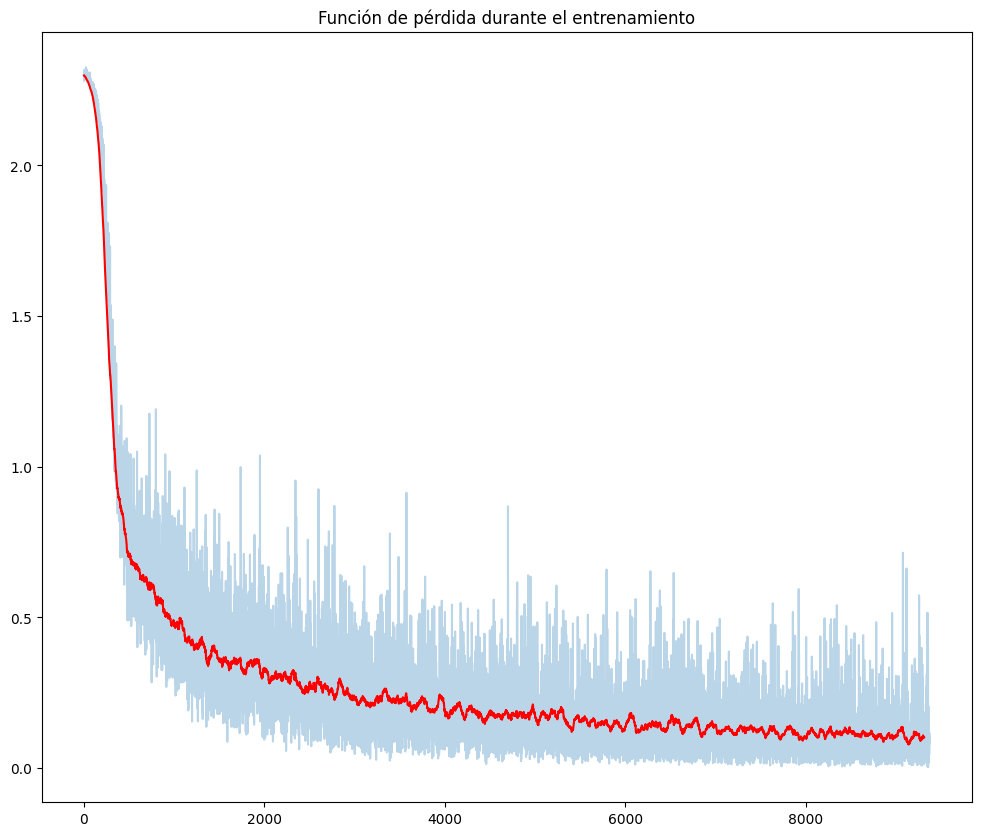

In [ ]:
# Parámetros
batch_size = 50
learning_rate = 0.0001

# Movemos los datos a GPU
device = torch.device('cuda:0')

# Instanciamos el modelo
net = NetCNN()
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar
# son los del modelo definido: net.parameters()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = torch.nn.CrossEntropyLoss()

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Número de épocas
num_epochs = 5

# Lista en la que iremos guardando el valor de la función de pérdida en cada
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)

        # Realizo la pasada backward por la red
        loss.backward()

        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


Guardamos el modelo.

In [ ]:
torch.save(net.state_dict(), "./cnn20.pth")

Cargamos el modelo y visualizamos los resultados en los datos de test y la matriz de confusión.

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.97      0.96      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.96      0.97      0.96       892
           6       0.99      0.97      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.94      0.96      0.95       974
           9       0.98      0.95      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



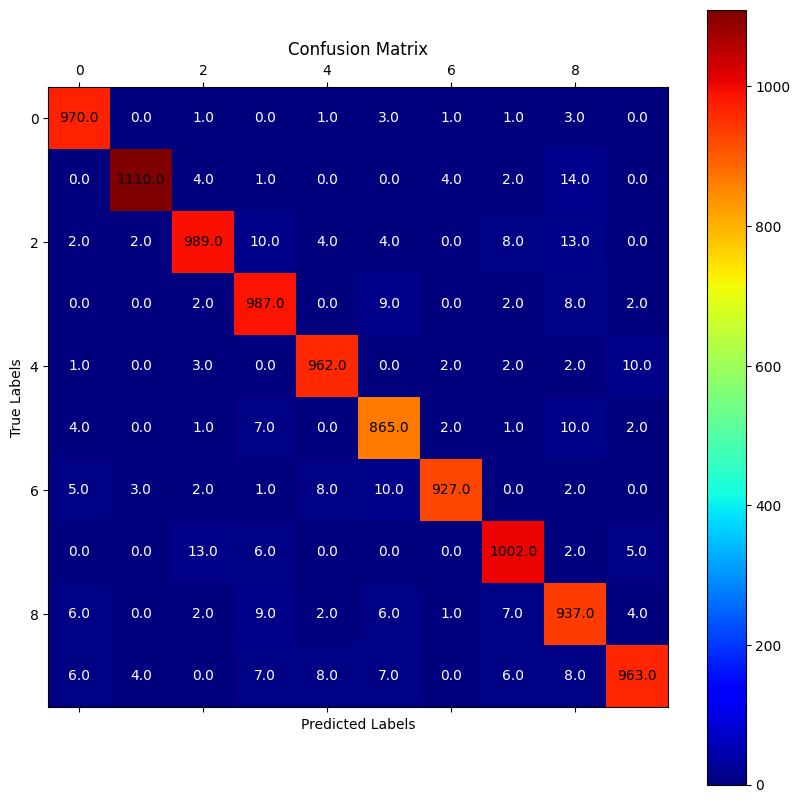

In [ ]:
# Cargamos el modelo
net = NetCNN()
net.load_state_dict(torch.load("./cnn20.pth"))
net.to(device)

# Mostramos los resultados
showTestResults(net)

Observamos que este modelo tiene un accuracy de 0.97. En este caso la clase con menos f1-score es el 8, que se confunde principalmente con el 3.

## Punto 3) Comparación de la accuracy obtenida por el perceptrón muticapa y la red neuronal convolucional.

Como podemos ver en la evaluación de los dos modelos, la acurracy de la red convolucional es superior a la del modelo MLP (0.97 versus 0.91).
En este sentido, la red convolucional posee mejores características para procesar las imagenes del dataset y determinar la clase que le corresponde (el número) debido a que se adaptan naturalmente a la estructura de las imágenes. También observamos que la función de pérdida en el entrenamiento converge a valores menores.